In [1]:
!pip -q install pandas numpy scikit-learn lightgbm xgboost catboost shap ipywidgets kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.7 MB/s eta 0:00:00


In [159]:
# 1. Install Kaggle API
!pip install kaggle --quiet

# 2. Upload kaggle.json (downloaded from your Kaggle account settings)
from google.colab import files
files.upload()  # <-- Select kaggle.json from your computer

# 3. Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download competition data (example: playground-series-s5e8)
!kaggle competitions download -c playground-series-s5e8 -p /content/data

# 5. Unzip files
!unzip -o /content/data/playground-series-s5e8.zip -d /content/data/playground

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

playground-series-s5e8.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/data/playground-series-s5e8.zip
  inflating: /content/data/playground/sample_submission.csv  
  inflating: /content/data/playground/test.csv  
  inflating: /content/data/playground/train.csv  


### mywork


In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
train_df=pd.read_csv('/content/data/playground/train.csv')
test_df=pd.read_csv('/content/data/playground/test.csv')
submission_df=pd.read_csv('/content/data/playground/sample_submission.csv')
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [198]:
print("Train Shape:",train_df.shape)
print("Test Shape:",test_df.shape)

Train Shape: (750000, 18)
Test Shape: (250000, 17)


In [199]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [200]:
# check for null values
train_df.isnull().sum()

,0
id,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0


In [201]:
# dataset description for numerical values
train_df.describe(include=['int64', 'float64'])

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [202]:
# dataset description for categorical values
train_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


In [203]:
# Check unique values in the categorical value columns
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        print(f"Unique values in column '{col}':")
        print(train_df[col].unique())


Unique values in column 'job':
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']
Unique values in column 'marital':
['married' 'single' 'divorced']
Unique values in column 'education':
['secondary' 'primary' 'tertiary' 'unknown']
Unique values in column 'default':
['no' 'yes']
Unique values in column 'housing':
['no' 'yes']
Unique values in column 'loan':
['no' 'yes']
Unique values in column 'contact':
['cellular' 'unknown' 'telephone']
Unique values in column 'month':
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']
Unique values in column 'poutcome':
['unknown' 'other' 'failure' 'success']


In [204]:
print(train_df["y"].value_counts())

y
0    659512
1     90488
Name: count, dtype: int64


In [205]:
## dropping id feature from train and test
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

# visualization


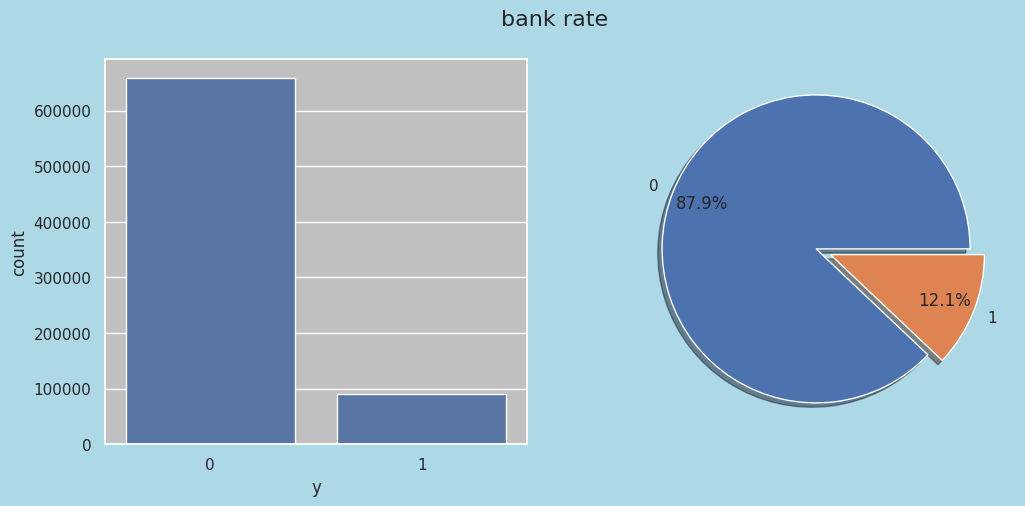

In [206]:
plt.figure(figsize=(12,5))
sns.set(rc={'axes.facecolor':'c0c0c0', 'figure.facecolor':'lightblue'})
plt.subplot(1, 2, 1)
sns.barplot(x=train_df["y"].value_counts().index, y=train_df["y"].value_counts())
plt.subplot(1, 2, 2)
plt.pie(x=train_df["y"].value_counts(), autopct="%.1f%%", pctdistance=0.8,
        labels= train_df["y"].value_counts().index, shadow=True, explode=[0.05,0.05])
plt.suptitle("bank rate", fontsize=16)
plt.show()

In [209]:
cat_fea_list = train_df.select_dtypes(include=['object']).columns.tolist()
cat_fea_list

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

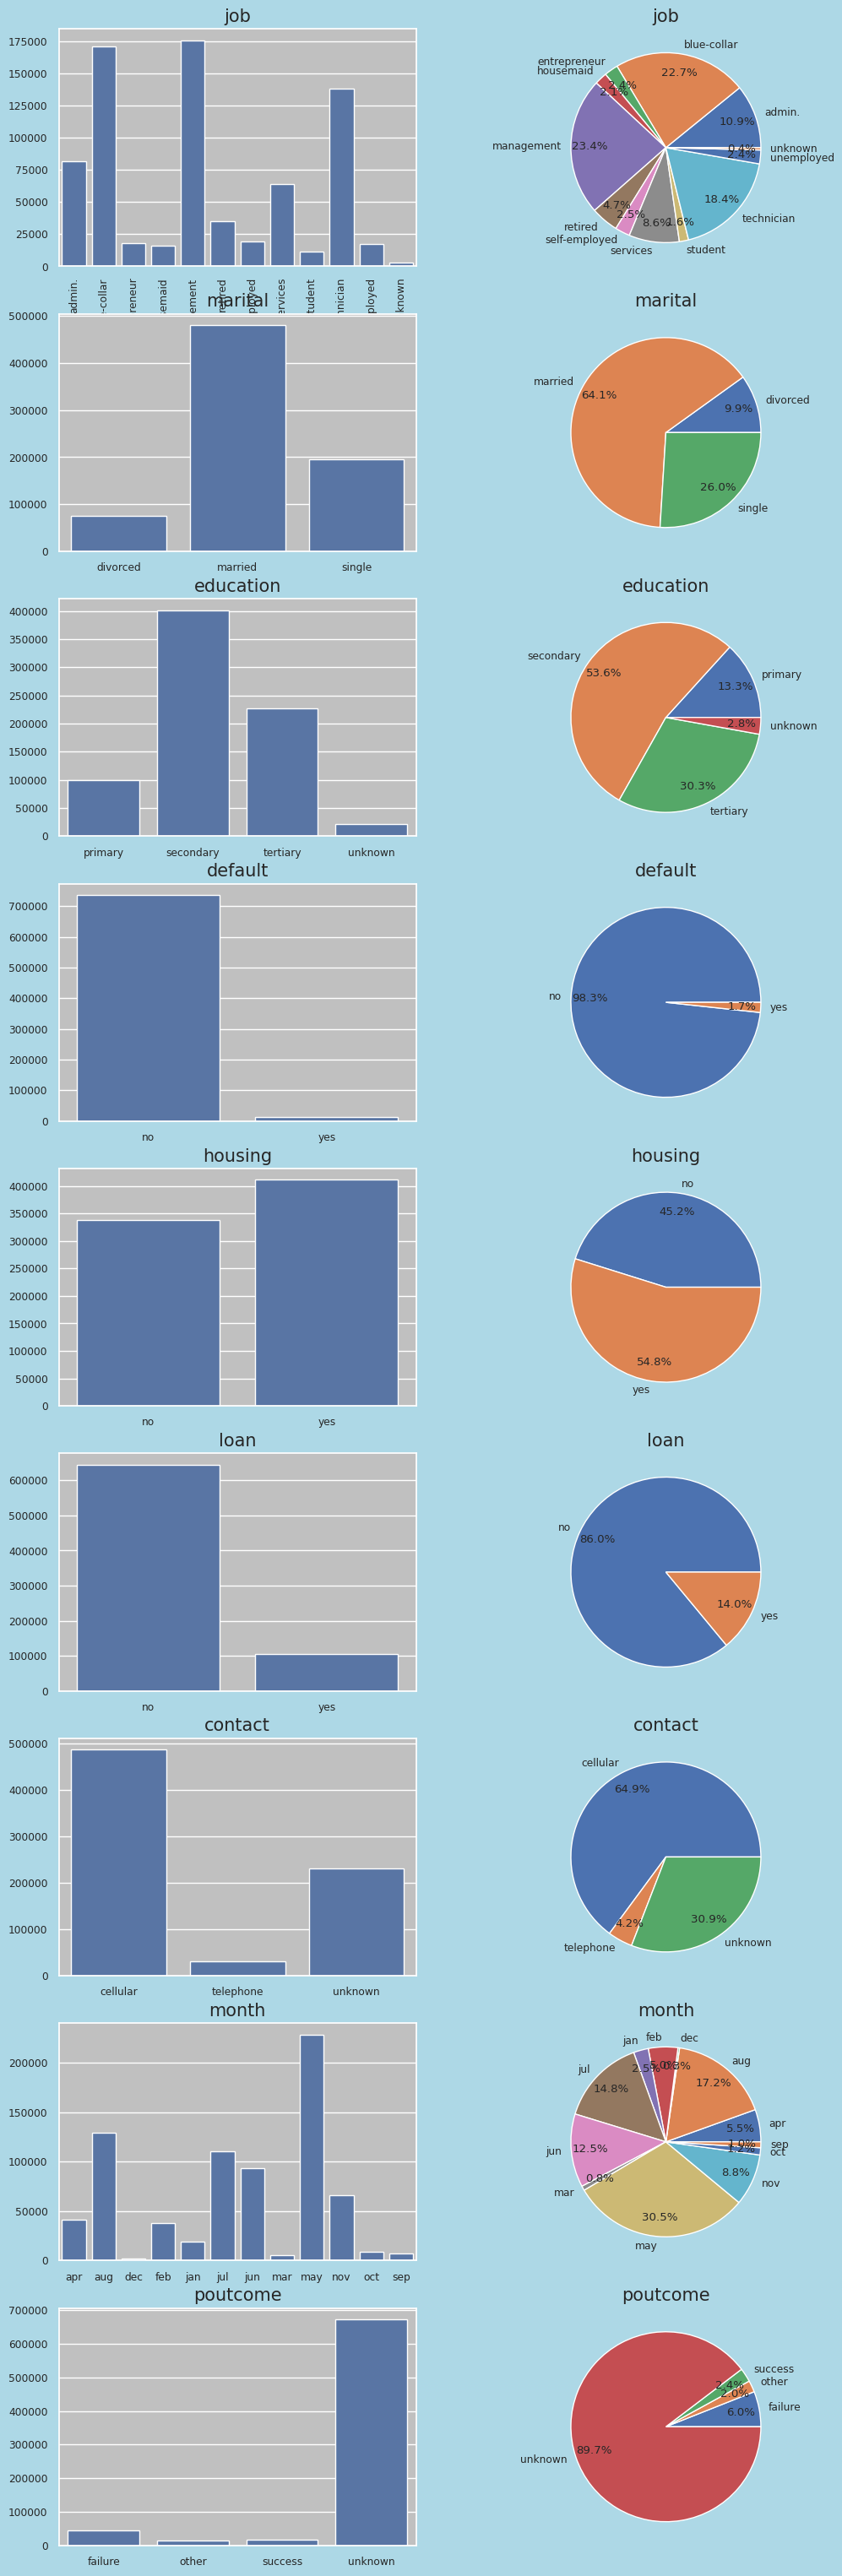

In [210]:
plt.figure(figsize=(12,65))
sns.set(rc={'axes.facecolor':'c0c0c0', 'figure.facecolor':'lightblue'}, font_scale=0.8)

i = 0
j = 0
for col in cat_fea_list:
    feature = train_df.groupby(col)[col].count()
    plt.subplot(15, 2, i+1)
    sns.barplot(x=feature.index, y=feature.values)
    plt.title(col, fontsize=15)
    plt.xlabel("")
    #plt.xlabel(col, fontsize=12, color="#8b1a1a")
    if col == "job":
        plt.xticks(rotation=90)

    plt.subplot(15, 2, j+2)
    plt.pie(x=feature.values, autopct="%.1f%%", pctdistance=0.8, labels=feature.index)
    plt.title(col, fontsize=15)
    #plt.xlabel(col, fontsize=12, color="#8b1a1a")
    i += 2
    j += 2
plt.show()

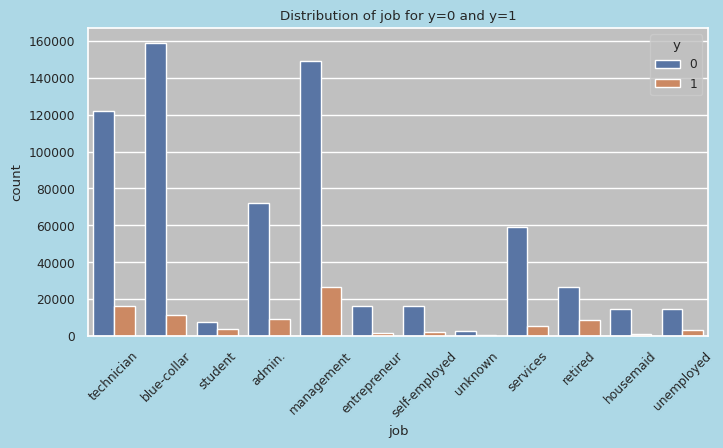

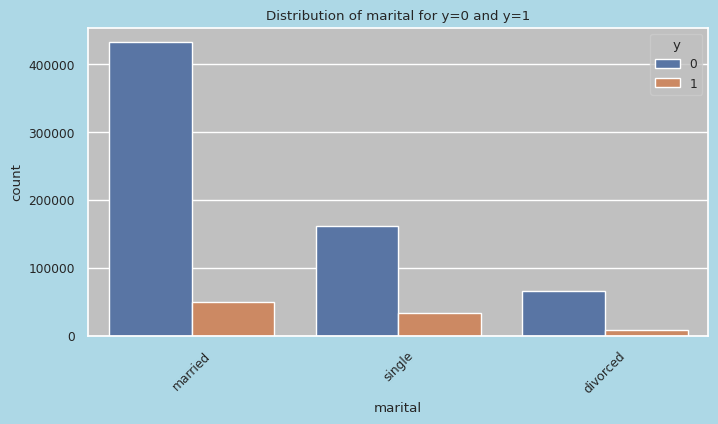

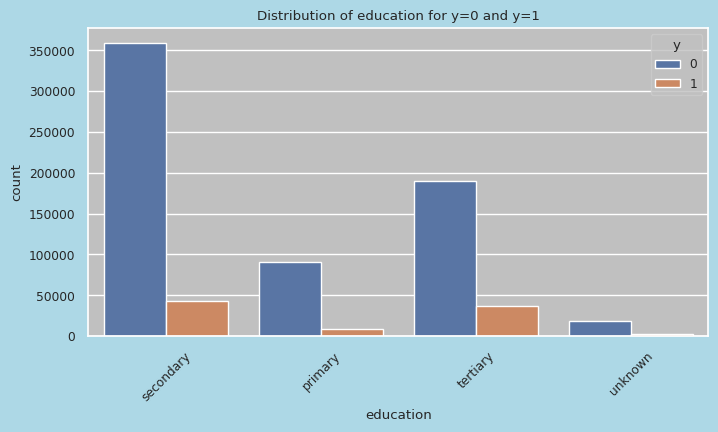

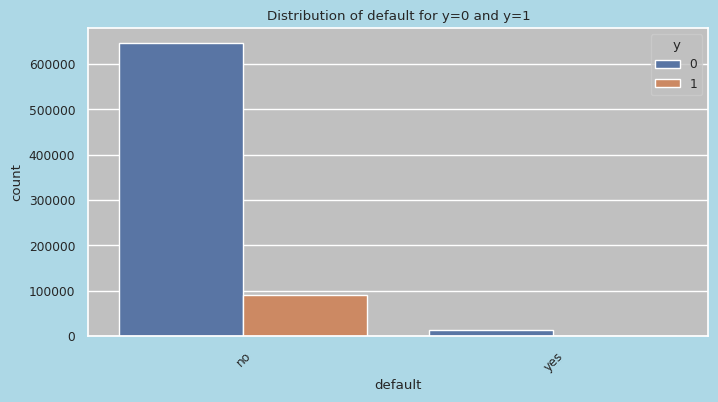

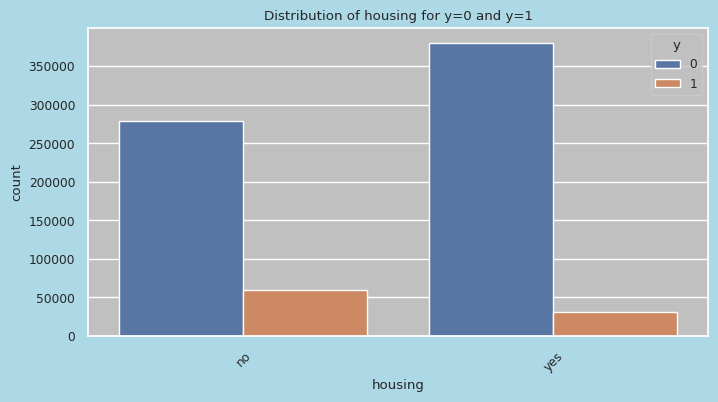

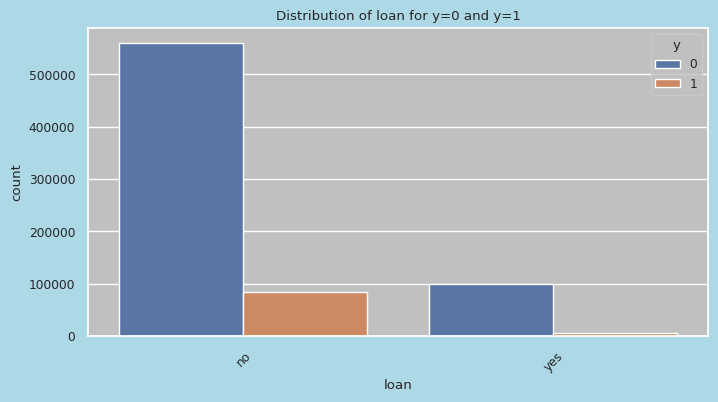

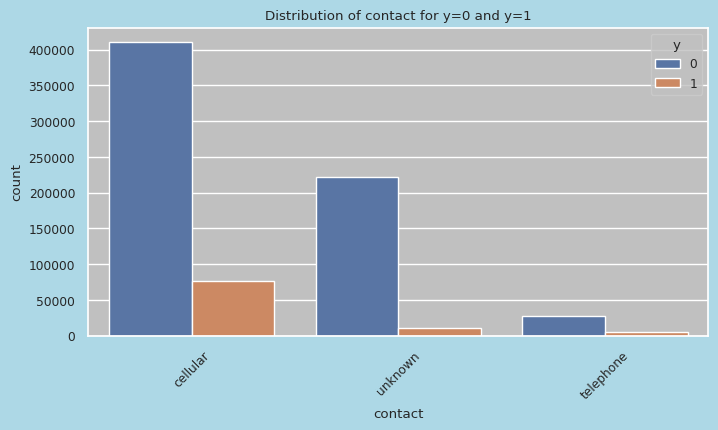

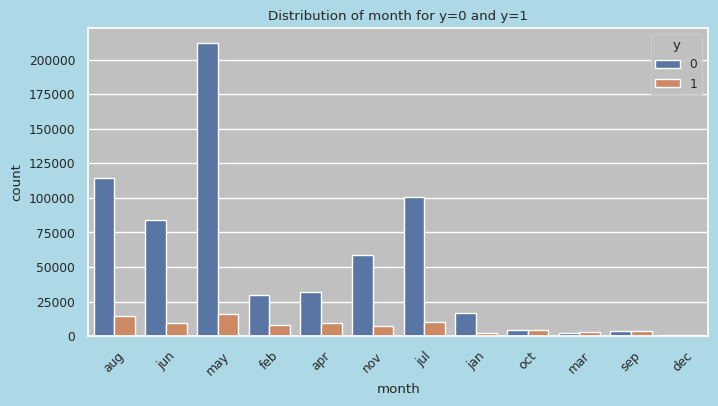

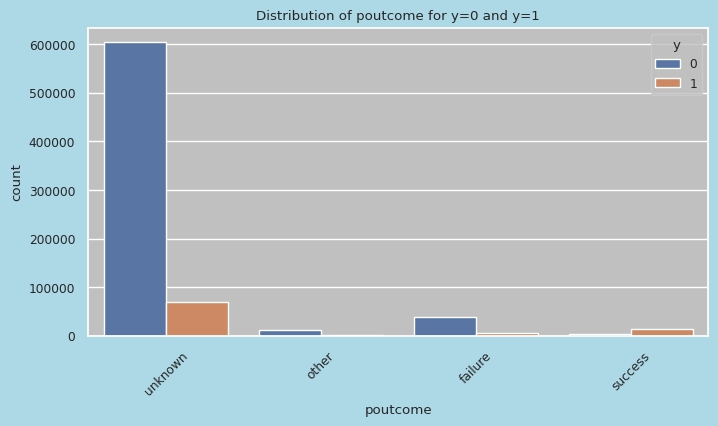

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train_df, x=col, hue='y')
    plt.title(f'Distribution of {col} for y=0 and y=1')
    plt.xticks(rotation=45)
    plt.show()

In [235]:
binary_cols = ['default', 'housing', 'loan']
train_df[binary_cols] = train_df[binary_cols].replace({'no': 0, 'yes': 1})
test_df[binary_cols] = test_df[binary_cols].replace({'no': 0, 'yes': 1})

## Removing all the outliers from each feature

In [237]:
def filter_outliers(df,feature):
    ## using z score method
    std = df[feature].std()
    average = df[feature].mean()

    ## lower bound
    lower_bound = average - 3*std
    upper_bound = average + 3*std

    df = df[(df[feature]>=lower_bound) & (df[feature]<=upper_bound)]
    return df

In [238]:
def return_outliers_using_zscore(df,feature):
    ## using z score method
    std = df[feature].std()
    average = df[feature].mean()

    ## lower bound
    lower_bound = average - 3*std
    upper_bound = average + 3*std

    outliers_in_df = df[(df[feature]<lower_bound) | (df[feature]>upper_bound)]
    return outliers_in_df

In [239]:
for i,feature in enumerate(train_df.columns,1):
    if train_df[feature].dtype!='O':
        print(f"\n{feature}--->")
        display(return_outliers_using_zscore(train_df,feature))
        print()
        if(i==1):
            outliers_df = return_outliers_using_zscore(train_df,feature)
        outliers_df = pd.concat([outliers_df,return_outliers_using_zscore(train_df,feature)])
        # outliers_df = pd.concat([outliers_df,return_outliers_using_zscore(train,feature)],ignore_index=True)
    else:
        print(f"{feature} is a categorical feature.....\n")


age--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
422,71,retired,married,tertiary,0,3812,0,0,cellular,25,sep,97,5,-1,0,unknown,0,65+
1249,71,retired,divorced,primary,0,5080,0,0,telephone,8,oct,350,2,-1,0,unknown,1,65+
1416,71,retired,divorced,tertiary,0,3895,0,0,cellular,21,aug,531,1,-1,0,unknown,1,65+
1510,71,retired,married,tertiary,0,2140,0,0,cellular,21,apr,216,2,-1,0,unknown,1,65+
3973,71,retired,married,primary,0,2376,0,0,telephone,17,sep,707,3,-1,0,unknown,1,65+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745820,71,retired,married,secondary,0,1696,0,0,cellular,3,jun,496,2,-1,0,unknown,1,65+
747483,71,retired,married,unknown,0,2600,0,0,cellular,9,sep,212,2,-1,0,unknown,1,65+
747571,71,unknown,married,tertiary,0,769,0,0,cellular,29,jan,486,1,92,2,success,0,65+
747847,71,retired,married,primary,0,641,1,0,cellular,27,oct,78,2,-1,0,unknown,0,65+



job is a categorical feature.....

marital is a categorical feature.....

education is a categorical feature.....


default--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group




balance--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
22,35,blue-collar,married,secondary,0,8648,0,0,unknown,6,jun,527,1,-1,0,unknown,0,26-35
35,38,blue-collar,married,secondary,0,8558,1,0,cellular,14,may,466,1,-1,0,unknown,0,36-50
39,58,retired,married,secondary,0,8332,0,0,cellular,12,aug,740,4,-1,0,unknown,0,51-65
174,48,unemployed,married,primary,0,5462,0,0,cellular,5,feb,63,1,-1,0,unknown,0,36-50
192,48,admin.,married,secondary,0,7303,0,0,cellular,1,mar,123,1,-1,0,unknown,0,36-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749726,43,management,married,tertiary,0,8016,1,0,cellular,7,may,422,1,-1,0,unknown,0,36-50
749729,50,services,divorced,secondary,0,8218,1,1,cellular,19,nov,67,2,111,2,failure,0,36-50
749759,51,management,married,tertiary,0,9683,0,0,cellular,5,aug,388,2,-1,0,unknown,1,51-65
749772,52,management,married,tertiary,0,8295,1,0,cellular,17,nov,846,3,-1,0,unknown,1,51-65




housing--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group




loan--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group



contact is a categorical feature.....


day--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group



month is a categorical feature.....


duration--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
5,24,admin.,single,secondary,0,1882,1,0,cellular,20,apr,1010,3,-1,0,unknown,0,18-25
68,30,services,single,secondary,0,535,0,0,cellular,20,nov,944,1,-1,0,unknown,1,26-35
112,39,management,married,secondary,0,1301,0,0,cellular,21,nov,988,7,-1,0,unknown,1,36-50
114,37,admin.,single,secondary,0,99,0,0,cellular,30,jan,968,1,-1,0,unknown,1,36-50
129,39,management,single,tertiary,0,1277,1,0,unknown,3,jun,984,2,-1,0,unknown,0,36-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749663,39,services,single,secondary,0,1510,1,0,cellular,17,nov,956,1,-1,0,unknown,1,36-50
749725,38,unemployed,single,secondary,0,3585,0,0,cellular,9,feb,935,3,-1,0,unknown,0,36-50
749828,30,services,married,secondary,0,466,1,0,cellular,8,dec,955,2,-1,0,unknown,1,26-35
749865,32,blue-collar,married,secondary,0,1034,1,0,cellular,21,nov,1055,1,-1,0,unknown,0,26-35




campaign--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
70,49,management,married,tertiary,0,4028,0,0,cellular,28,aug,7,9,-1,0,unknown,0,36-50
144,43,blue-collar,divorced,primary,0,1401,0,1,unknown,6,jun,682,8,-1,0,unknown,0,36-50
160,40,services,married,primary,0,89,1,0,cellular,21,jul,528,10,-1,0,unknown,0,36-50
171,46,management,married,tertiary,0,658,0,0,cellular,25,aug,78,8,-1,0,unknown,0,36-50
272,39,management,married,tertiary,0,0,0,0,cellular,28,aug,74,10,-1,0,unknown,0,36-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749695,60,unknown,married,primary,0,578,0,0,telephone,12,may,33,8,-1,0,unknown,0,51-65
749715,43,management,married,tertiary,0,1206,0,0,cellular,19,aug,157,9,-1,0,unknown,0,36-50
749861,36,admin.,divorced,secondary,0,305,1,0,telephone,15,may,672,9,-1,0,unknown,0,36-50
749925,27,blue-collar,married,primary,0,622,1,0,cellular,18,may,10,8,-1,0,unknown,0,26-35




pdays--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
23,32,technician,married,secondary,0,707,1,1,cellular,18,nov,41,1,175,3,other,0,26-35
36,67,retired,divorced,secondary,0,1531,0,0,cellular,13,jul,136,1,181,2,failure,0,65+
37,33,services,single,secondary,0,-68,1,0,cellular,2,feb,393,1,252,1,failure,0,26-35
74,54,management,married,tertiary,0,913,1,0,cellular,3,feb,881,3,211,2,failure,1,51-65
88,60,technician,married,secondary,0,116,0,0,cellular,29,jul,795,2,183,4,success,1,51-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749670,28,technician,single,secondary,0,953,1,0,cellular,2,feb,131,2,189,4,failure,0,26-35
749749,40,management,married,tertiary,0,935,1,0,cellular,19,nov,113,1,174,1,failure,0,36-50
749835,32,admin.,single,secondary,0,4344,1,0,cellular,2,jun,86,2,120,3,failure,0,26-35
749946,56,retired,divorced,tertiary,0,1454,1,0,cellular,15,apr,141,2,146,2,other,0,51-65




previous--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group
23,32,technician,married,secondary,0,707,1,1,cellular,18,nov,41,1,175,3,other,0,26-35
36,67,retired,divorced,secondary,0,1531,0,0,cellular,13,jul,136,1,181,2,failure,0,65+
42,59,admin.,married,secondary,0,2338,0,0,cellular,10,mar,472,1,90,3,success,1,51-65
74,54,management,married,tertiary,0,913,1,0,cellular,3,feb,881,3,211,2,failure,1,51-65
88,60,technician,married,secondary,0,116,0,0,cellular,29,jul,795,2,183,4,success,1,51-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749729,50,services,divorced,secondary,0,8218,1,1,cellular,19,nov,67,2,111,2,failure,0,36-50
749770,36,management,married,tertiary,0,495,0,0,cellular,12,aug,120,2,104,3,failure,0,36-50
749835,32,admin.,single,secondary,0,4344,1,0,cellular,2,jun,86,2,120,3,failure,0,26-35
749946,56,retired,divorced,tertiary,0,1454,1,0,cellular,15,apr,141,2,146,2,other,0,51-65



poutcome is a categorical feature.....


y--->


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group




age_group--->


TypeError: 'Categorical' with dtype category does not support reduction 'std'

In [ ]:
outliers_df.shape

In [ ]:
outliers_df[outliers_df.duplicated()]

In [ ]:
outliers_df = outliers_df.drop_duplicates()

In [ ]:
outliers_df.shape

In [ ]:
outliers_df[outliers_df.duplicated()]

In [ ]:
outliers_df

In [ ]:
train_df = train_df.drop(outliers_df.index)

In [ ]:
train_df

In [ ]:
train_df.shape

#### ----------- Here Removed all the outleirs from train df --------------

In [240]:
from sklearn.model_selection import train_test_split

# Separate features and target for label-encoded data
X = train_df.drop(['y'], axis=1)
y = train_df['y']

print("X_train_label shape:", X.shape)
print("y_train_label shape:", y.shape)



X_train_label shape: (659821, 17)
y_train_label shape: (659821,)


# feature engineering on train data

In [241]:
# Define bins
bins = [18, 25, 35, 50, 65, 100]
labels = ['18-25', '26-35', '36-50', '51-65', '65+']

# Apply binning
train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, right=True)
test_df['age_group'] = pd.cut(test_df['age'], bins=bins, labels=labels, right=True)

In [242]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
# Get categorical columns (excluding target 'y')
categorical_cols = train_df.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols_test = test_df.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols


['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_group']

In [260]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
# Get categorical columns (excluding target 'y')
categorical_cols = train_df.select_dtypes(include=['object','category']).columns.tolist()

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols])
test_df[categorical_cols]  = encoder.transform(test_df[categorical_cols])
# Check shapes
print("Label Encoded dataset shape:", train_df.shape)

Label Encoded dataset shape: (659821, 20)


In [261]:
# Test (apply same lo/hi from train)
lotest, hitest = np.percentile(test_df["balance"], [1, 99])
b_test = np.clip(test_df["balance"], lotest, hitest)
test_df["balance_slog"] = np.sign(b_test) * np.log1p(np.abs(b_test))

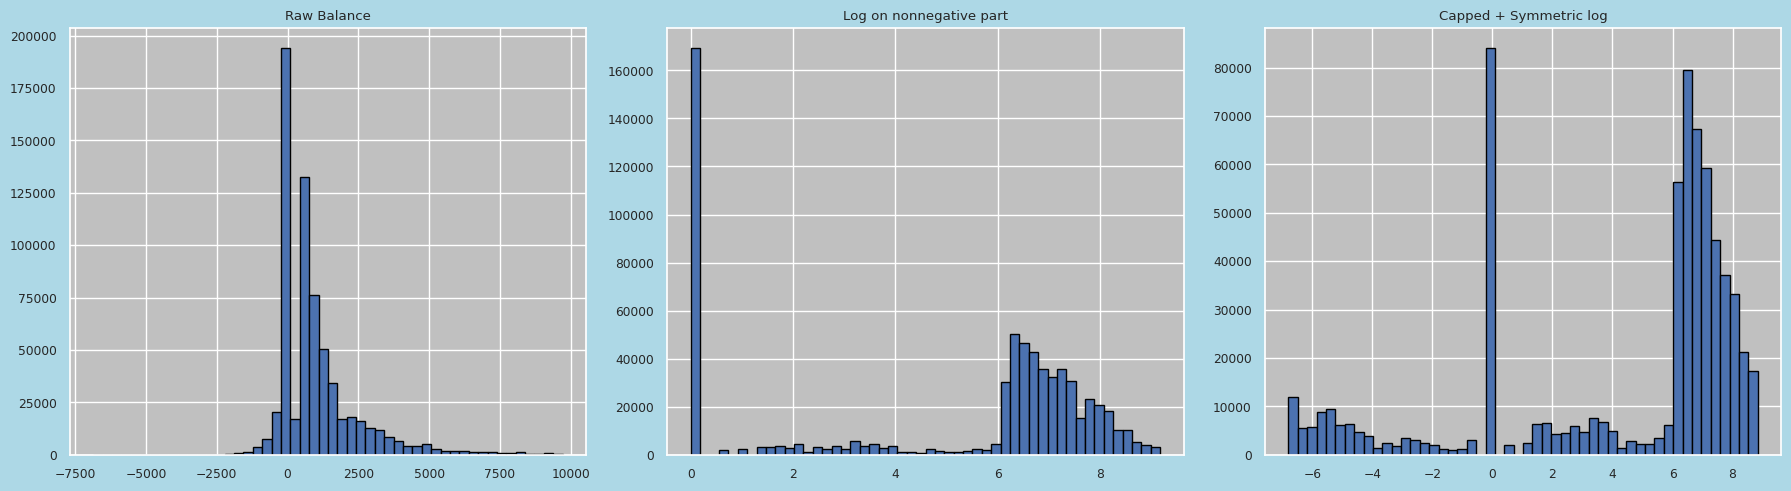

In [262]:
b = train_df["balance"].copy()

# 1) Winsorize / cap both tails (e.g., 1st–99th pct)
lo, hi = np.percentile(b, [1, 99])
b = np.clip(b, lo, hi)

# 2) Symmetric log transform (a.k.a. signed log)
balance_slog = np.sign(b) * np.log1p(np.abs(b))   # or use np.arcsinh(b)
# 3) Plot safely
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axes[0].hist(train_df["balance"].dropna(), bins=50, edgecolor="black")
axes[0].set_title("Raw Balance")

axes[1].hist(np.log1p(np.clip(train_df["balance"], 0, None)).replace([np.inf, -np.inf], np.nan).dropna(),
             bins=50, edgecolor="black")
axes[1].set_title("Log on nonnegative part")

axes[2].hist(balance_slog.dropna(), bins=50, edgecolor="black")
axes[2].set_title("Capped + Symmetric log")
plt.tight_layout(); plt.show()

# Keep engineered feature
train_df["balance_slog"] = balance_slog

In [263]:
# ---- Fit on training only ----
# 1. pdays
pdays_cap = train_df['pdays'].replace(-1, np.nan)
pdays_cap = pdays_cap.clip(upper=pdays_cap.quantile(0.99))   # get cap threshold from train
pdays_cap = np.log1p(pdays_cap)                             # log transform
train_df['pdays_cap'] = pdays_cap.fillna(0)                  # fill missing with 0 (or keep separate flag)

# 2. campaign & previous
for col in ['campaign', 'previous']:
    cap_val = train_df[col].quantile(0.99)                   # cap threshold from train
    train_df[col] = np.log1p(train_df[col].clip(upper=cap_val))

# ---- Apply same rules to test ----
# pdays
pdays_cap_test = test_df['pdays'].replace(-1, np.nan)
pdays_cap_test = pdays_cap_test.clip(upper=cap_val)   # use train's cap
pdays_cap_test = np.log1p(pdays_cap_test)
test_df['pdays_cap'] = pdays_cap_test.fillna(0)

# campaign & previous
for col in ['campaign', 'previous']:
    test_df[col] = np.log1p(test_df[col].clip(upper=cap_val))  # reuse train cap


In [264]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,balance_slog,pdays_cap
0,42,9.0,1.0,1.0,0,7,0,0,0.0,25,1.0,117,0.869742,-1,0.0,3.0,0,2.0,2.079442,0.0
1,38,1.0,1.0,1.0,0,514,0,0,2.0,18,6.0,185,0.526589,-1,0.0,3.0,0,2.0,6.244167,0.0
2,36,1.0,1.0,1.0,0,602,1,0,2.0,14,8.0,111,0.741276,-1,0.0,3.0,0,2.0,6.401917,0.0
3,27,8.0,2.0,1.0,0,34,1,0,2.0,28,8.0,10,0.741276,-1,0.0,3.0,0,1.0,3.555348,0.0
4,26,9.0,1.0,1.0,0,889,1,0,0.0,3,3.0,902,0.526589,-1,0.0,3.0,1,1.0,6.791221,0.0


In [265]:
train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y',
 'age_group',
 'balance_slog',
 'pdays_cap']

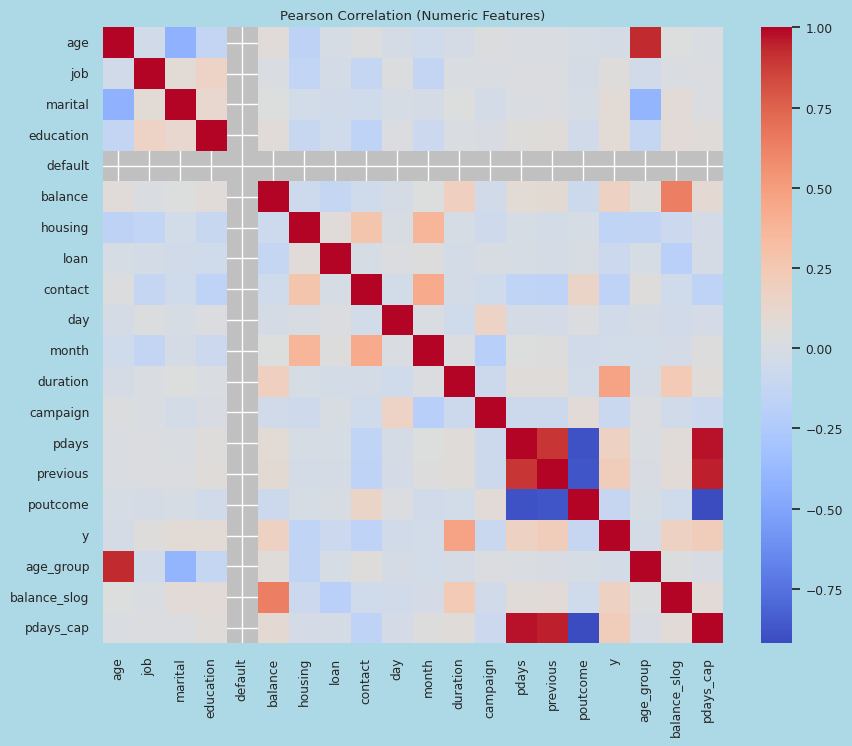

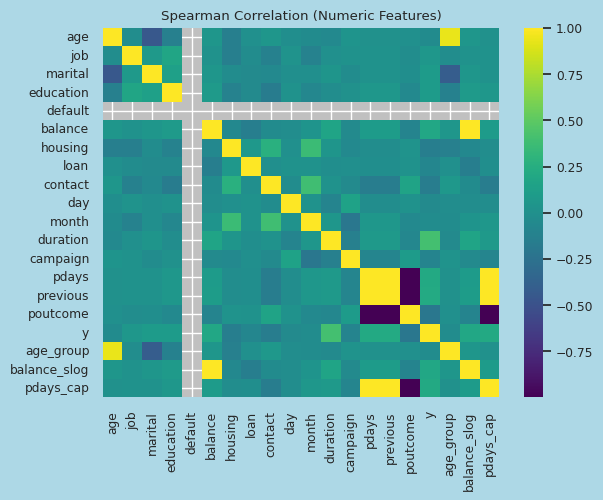

In [253]:
# Pearson correlation (linear)
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(method='pearson'), annot=False, cmap="coolwarm")
plt.title("Pearson Correlation (Numeric Features)")
plt.show()

# Spearman correlation (rank-based, handles non-linear monotonic)
sns.heatmap(train_df.corr(method='spearman'), annot=False, cmap="viridis")
plt.title("Spearman Correlation (Numeric Features)")
plt.show()

# Model


In [268]:
lgbm_best_params ={'n_estimators': 1582,
                     'max_depth': 15,
                     'learning_rate': 0.04436352313699452,
                     'num_leaves': 77,
                     'min_child_samples': 81,
                     'subsample': 0.8677563315146003,
                     'colsample_bytree': 0.5261353954090011,
                     'reg_alpha': 0.0631139742323974,
                     'reg_lambda': 6.686183660331108,
                     'verbose': -1,
                     'random_state': 42
                  }

In [269]:
lgbm_best_params_new = {
    'n_estimators': 1868, 'max_depth': 8, 'learning_rate': 0.02747336307650047, 'num_leaves': 2674, 'min_child_samples': 26, 'subsample': 0.7168173262481119, 'colsample_bytree': 0.6270912795327223, 'reg_alpha': 1.842038013666194, 'reg_lambda': 5.239502741979393, 'verbose':-1
}

# Till 14th trial

In [270]:
!pip install catboost --quiet
!pip install xgboost --quiet
!pip install lightgbm --quiet

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

## importing accuraty measures
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score,roc_auc_score
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold

In [279]:
X = train_df.drop('y',axis=1)
y = train_df['y']

In [280]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_group,balance_slog,pdays_cap
0,42,9.0,1.0,1.0,0,7,0,0,0.0,25,1.0,117,0.869742,-1,0.0,3.0,2.0,2.079442,0.0
1,38,1.0,1.0,1.0,0,514,0,0,2.0,18,6.0,185,0.526589,-1,0.0,3.0,2.0,6.244167,0.0
2,36,1.0,1.0,1.0,0,602,1,0,2.0,14,8.0,111,0.741276,-1,0.0,3.0,2.0,6.401917,0.0
3,27,8.0,2.0,1.0,0,34,1,0,2.0,28,8.0,10,0.741276,-1,0.0,3.0,1.0,3.555348,0.0
4,26,9.0,1.0,1.0,0,889,1,0,0.0,3,3.0,902,0.526589,-1,0.0,3.0,1.0,6.791221,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749994,31,3.0,2.0,1.0,0,594,0,0,0.0,4,3.0,137,0.526589,-1,0.0,3.0,1.0,6.388561,0.0
749995,29,7.0,2.0,1.0,0,1282,0,1,2.0,4,5.0,1006,0.741276,-1,0.0,3.0,1.0,7.156956,0.0
749996,69,5.0,0.0,2.0,0,631,0,0,0.0,19,1.0,87,0.526589,-1,0.0,3.0,4.0,6.448889,0.0
749997,50,1.0,1.0,1.0,0,217,1,0,0.0,17,0.0,113,0.526589,-1,0.0,3.0,2.0,5.384495,0.0


In [281]:
from datetime import datetime
start_time = datetime.now()

## Model Training -->
models = {
    # "GradientBoostingClassifier": GradientBoostingClassifier(),

    # "XGBClassifier_with_optuna": XGBClassifier(n_jobs=-1,**xgb_best_params),

    # "XGBClassifier": XGBClassifier(n_jobs=-1),

    "LGBMClassifier_with_optuna1": LGBMClassifier(**lgbm_best_params_new),
    "LGBMClassifier_with_optuna2": LGBMClassifier(**lgbm_best_params),
    "LGBMClassifier": LGBMClassifier(verbose=-1),

    # "LGBMClassifier": LGBMClassifier(),

    # "CatBoostClassifier_with_optuna":CatBoostClassifier(**catboost_best_params),

    # "CatBoostClassifier":CatBoostClassifier(),

    # "RandomForestClassifier": RandomForestClassifier(n_jobs=-1),
}


num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_pred = np.zeros(test_df.shape[0])
print(test_pred.shape)
model_name_list=[]
avg_cv_score_list=[]


for model_name, model in models.items():
    test_pred = np.zeros(test_df.shape[0])
    score_list = [] ## score list to store score of each fold
    print(f"\n<==============={model_name}===============>\n")
    model_name_list.append(model_name)

    print("Model ->",model)

    ## applying StratifiedKFold cross validation
    for fold, (train_idx,test_idx) in enumerate(skf.split(X,y),1):

        fold_model = LGBMClassifier(**lgbm_best_params_new)

        X_train_fold,X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold,y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        fold_model.fit(X_train_fold,y_train_fold)
        y_test_fold_pred = fold_model.predict_proba(X_test_fold)[:,1]

        score = roc_auc_score(y_test_fold,y_test_fold_pred)

        ## prediction on X_val
        val_preds = fold_model.predict(X_test_fold)
        oof_preds[test_idx] = val_preds

        print(f"Fold {fold}: Score : {score:.4f}")
        score_list.append(score)

        test_pred+=fold_model.predict_proba(test_df)[:,1] ## for class 1


    print(f"\n Average Score : {np.mean(score_list):.4f}\n")
    avg_cv_score_list.append(np.mean(score_list))

    print()
    training_score = roc_auc_score(y, oof_preds)
    print(f"\nAUC Score of complete train data: {training_score:.5f}")

    # Average test predictions over all folds
    test_pred /= num_folds

    ## saving prediction in submission file
    submission_df['y'] = test_pred
    submission_df.to_csv(f"{model_name}_prediction.csv",index=False)
    display(submission_df.head())
    print(f"File saved as {model_name}_prediction.csv.....\n")

# ------------------------------------------------------------------------------

## dataframe to measue performance of each model
performace_df = pd.DataFrame({
    'ML Algorithm': model_name_list,
    'Mean CV Score (StratifiedKFold)': avg_cv_score_list
})

print()
end_time = datetime.now()
total_time = end_time - start_time
print("Total Training Time:", total_time)

(250000,)

<===============LGBMClassifier_with_optuna1===============>

Model -> LGBMClassifier(colsample_bytree=0.6270912795327223,
               learning_rate=0.02747336307650047, max_depth=8,
               min_child_samples=26, n_estimators=1868, num_leaves=2674,
               reg_alpha=1.842038013666194, reg_lambda=5.239502741979393,
               subsample=0.7168173262481119, verbose=-1)
Fold 1: Score : 0.9695
Fold 2: Score : 0.9685
Fold 3: Score : 0.9673
Fold 4: Score : 0.9678
Fold 5: Score : 0.9692

 Average Score : 0.9684



AUC Score of complete train data: 0.81122


,id,y
0,750000,0.001651
1,750001,0.092028
2,750002,0.000215
3,750003,0.000099
4,750004,0.017140


File saved as LGBMClassifier_with_optuna1_prediction.csv.....


<===============LGBMClassifier_with_optuna2===============>

Model -> LGBMClassifier(colsample_bytree=0.5261353954090011,
               learning_rate=0.04436352313699452, max_depth=15,
               min_child_samples=81, n_estimators=1582, num_leaves=77,
               random_state=42, reg_alpha=0.0631139742323974,
               reg_lambda=6.686183660331108, subsample=0.8677563315146003,
               verbose=-1)
Fold 1: Score : 0.9695
Fold 2: Score : 0.9685
Fold 3: Score : 0.9673
Fold 4: Score : 0.9678
Fold 5: Score : 0.9692

 Average Score : 0.9684



AUC Score of complete train data: 0.81122


,id,y
0,750000,0.001651
1,750001,0.092028
2,750002,0.000215
3,750003,0.000099
4,750004,0.017140


File saved as LGBMClassifier_with_optuna2_prediction.csv.....


<===============LGBMClassifier===============>

Model -> LGBMClassifier(verbose=-1)
Fold 1: Score : 0.9695
Fold 2: Score : 0.9685
Fold 3: Score : 0.9673
Fold 4: Score : 0.9678
Fold 5: Score : 0.9692

 Average Score : 0.9684



AUC Score of complete train data: 0.81122


,id,y
0,750000,0.001651
1,750001,0.092028
2,750002,0.000215
3,750003,0.000099
4,750004,0.017140


File saved as LGBMClassifier_prediction.csv.....


Total Training Time: 1:07:59.687317
